In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seasborn as sns
%matplotlib inline



In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation,Bidirectional, Lambda, Dot
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from keras.activations import softmax
from keras.layers import Bidirectional,dot, Reshape, add, BatchNormalization, concatenate,Flatten
from keras.layers import Lambda, Permute, Concatenate, Multiply,GlobalAvgPool1D,GlobalMaxPool1D
from keras import backend as K

Initial Data Visualization

In [ ]:
train  = pd.read_csv("train.csv").fillna("")
train.head()
test = pd.read_csv("test.csv").fillna("")
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


is_duplicate
0    255027
1    149263
Name: id, dtype: int64
537933
157


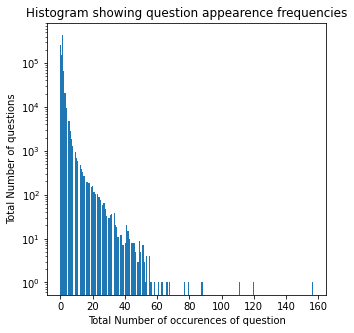

In [ ]:
#class imbalance
print (train.groupby("is_duplicate")['id'].count())
ids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
#unique ids
print (len(np.unique(ids)))
plt.figure(figsize=(5, 5))
plt.hist(ids.value_counts(), bins=200)
plt.yscale('log')
plt.title('Histogram showing question appearence frequencies')
plt.xlabel('Total Number of occurences of question')
plt.ylabel('Total Number of questions')
#Max number of times a question has appeared
print (max(ids.value_counts()))

plt.bar([0, 1], [255027, 149263])
plt.show()

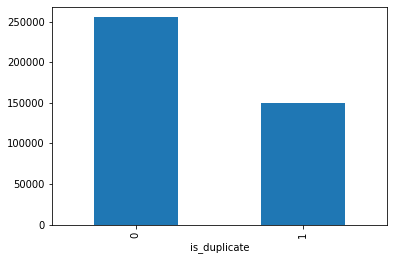

In [ ]:
train.groupby("is_duplicate")['id'].count().plot.bar()

In [ ]:
train['length_q1'] = train['question1'].str.len() 
train['length_q2'] = train['question2'].str.len()

train.head()

,id,qid1,qid2,question1,question2,is_duplicate,length_q1,length_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39


In [ ]:
train['words_q1'] = train['question1'].apply(lambda row: len(row.split(" ")))
train['words_q2'] = train['question2'].apply(lambda row: len(row.split(" ")))
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,length_q1,length_q2,words_q1,words_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7


In [ ]:
from sklearn.preprocessing import StandardScaler
combine  = pd.concat([train[['question1', 'question2']], test[['question1', 'question2']]], axis=0).reset_index(drop='index')
combine.head()
from collections import defaultdict
dictionary = defaultdict(set)
for i in range(combine.shape[0]):
        dictionary[combine.question1[i]].add(combine.question2[i])
        dictionary[combine.question2[i]].add(combine.question1[i])

def similar_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))        
def netq1_f(row):
    return(len(dictionary[row['question1']]))    
def netq2_f(row):
    return(len(dictionary[row['question2']]))    
def netpair_f(row):
    return(len(set(dictionary[row['question1']]).intersection(set(dictionary[row['question2']]))))
train['similar_word'] = train.apply(similar_words, axis=1)
train['netpair_f'] = train.apply(netpair_f, axis=1, raw=True)
train['netq1_f'] = train.apply(netq1_f, axis=1, raw=True)
train['netq2_f'] = train.apply(netq2_f, axis=1, raw=True)

test['netpair_f'] = test.apply(netpair_f, axis=1, raw=True)
test['netq1_f'] = test.apply(netq1_f, axis=1, raw=True)
test['netq2_f'] = test.apply(netq2_f, axis=1, raw=True)
test['similar_word'] = test.apply(similar_words,axis = 1)
train_extra = train[[ 'netq1_f', 'netq2_f','netpair_f','similar_word']]
test_extra = test[[ 'netq1_f', 'netq2_f','netpair_f','similar_word']]
scaling = StandardScaler()
scaling.fit(np.vstack((train_extra, test_extra)))
train_extra = scaling.transform(train_extra)
test_extra = scaling.transform(test_extra)

Processing of Data

In [ ]:
from nltk.stem import PorterStemmer
import re

In [ ]:
#Stopwords were not removed because they might have crucial info as we are dealing with questions in the context
def text_to_word(text):

    text = str(text)
    text = text.lower()
    text = re.sub(r"[^A-Za-z0-9]", " ", text)
    text = re.sub(r"what's", "", text)
    text = re.sub(r"What's", "", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r" m ", " am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"60k", " 60000 ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)

    ps = PorterStemmer()
    text = text.split()
    stemmed_words = [ps.stem(word) for word in text]
    text = " ".join(stemmed_words)
    
    return(text)

In [ ]:
#cleaning data
train_q1 = []
train_q2 = []
test_q1 = []
test_q2 = []
for item in train['question1']:
  train_q1.append(text_to_word(item))
for item in train['question2']:
  train_q2.append(text_to_word(item))
for item in test['question1']:
  test_q1.append(text_to_word(item))
for item in test['question2']:
  test_q2.append(text_to_word(item))   


In [ ]:
train['q1_clean'] = train_q1
train['q2_clean'] = train_q2
test['q1_clean'] = test_q1
test['q2_clean'] = test_q2
train.head()


,id,qid1,qid2,question1,question2,is_duplicate,length_q1,length_q2,words_q1,words_q2,similar_word,netpair_f,netq1_f,netq2_f,q1_clean,q2_clean
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,14,12,0.434783,0,1,2,what is the step by step guid to invest in sha...,what is the step by step guid to invest in sha...
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,8,13,0.200000,0,8,3,what is the stori of kohinoor koh i noor diamond,what would happen if the indian govern stole t...
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,10,0.166667,0,2,1,how can i increas the speed of my internet con...,how can internet speed be increas by hack thro...
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,50,65,11,9,0.000000,0,1,1,whi am i mental veri lone how can i solv it,find the remaind when math 23 24 math is divid...
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,76,39,13,7,0.100000,0,3,1,which one dissolv in water quikli sugar salt m...,which fish would surviv in salt water


In [ ]:
#Tokenisation
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_q1+train_q2+test_q1+test_q2)
train['q1_tokenised'] = tokenizer.texts_to_sequences(train['q1_clean'])
train['q2_tokenised'] = tokenizer.texts_to_sequences(train['q2_clean'])
test['q1_tokenised'] = tokenizer.texts_to_sequences(test['q1_clean'])
test['q2_tokenised'] = tokenizer.texts_to_sequences(test['q2_clean'])



In [ ]:
#Apply padding
from keras.preprocessing.sequence import pad_sequences
q1_train_padded = pad_sequences(train['q1_tokenised'], maxlen=30)
q2_train_padded = pad_sequences(train['q2_tokenised'], maxlen=30)
q1_test_padded = pad_sequences(test['q1_tokenised'], maxlen=30)
q2_test_padded = pad_sequences(test['q2_tokenised'], maxlen=30)


In [ ]:
#Data Augmentation
final_train_q1 = np.vstack((q1_train_padded,q2_train_padded))
final_train_q2 = np.vstack((q2_train_padded,q1_train_padded))
final_train_extra = np.vstack((train_extra,train_extra))
final_test_q1 = np.vstack((q1_test_padded,q2_test_padded))
final_test_q2 = np.vstack((q2_test_padded,q1_test_padded))
final_test_extra = np.vstack((test_extra,test_extra))

In [ ]:
labels_train = np.concatenate((train['is_duplicate'], train['is_duplicate']))


In [ ]:
#Embeddings Use this format for txt/vec file have glove and fasttext files for these
embeddingfile = 'glove.6B.300d.txt'
#embeddingfile = 'wiki-news-300d-1M.vec'
embeddings_index = {}
f = open(embeddingfile)
count = 0
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()


#Embedding use this format for .bin file, for googlenews file use the code below

#embeddingfile = 'GoogleNews-vectors-negative300.bin.gz'
#embeddings_index = {}
#from gensim.models import KeyedVectors
#wv_from_bin = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True) 
#for word, vector in zip(wv_from_bin.vocab, wv_from_bin.vectors):
#    coefs = np.asarray(vector, dtype='float32')
#    embeddings_index[word] = coefs

In [ ]:
a = np.max(final_test_q1.max())
b = np.max(final_test_q2.max())
c = np.max(final_train_q1.max())
d = np.max(final_train_q2.max())
Total_words = max(a,b,c,d)

nb_words = min(Total_words, len(tokenizer.word_index))+1

embedding_matrix = np.zeros((nb_words, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)

    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
#MaLSTM model
embedding_layer = Embedding(nb_words,300,weights=[embedding_matrix],input_length=30,trainable=False)
lstm = LSTM(200)
q1 = Input(shape=(30,),)
q2 = Input(shape=(30,),)
a1 = embedding_layer(q1)
a2 = embedding_layer(q2)
x1 = lstm(a1)
x2 = lstm(a2)
def exponential_negative_manhattan_distance(left, right):
     return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))
d = Lambda(function=lambda x: exponential_negative_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([x1, x2])

In [ ]:
#Siamese model
embedding_layer = Embedding(nb_words,300,weights=[embedding_matrix],input_length=30,trainable=False)
lstm = LSTM(200)
q1 = Input(shape=(30,),)
q2 = Input(shape=(30,),)
a1 = embedding_layer(q1)
a2 = embedding_layer(q2)
x1 = lstm(a1)
x2 = lstm(a2)
x = concatenate([x1,x2])
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(200, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
y_pred = Dense(1, activation='sigmoid')(x)

In [ ]:
embedding_layer = Embedding(nb_words,300,weights=[embedding_matrix],input_length=30,trainable=False)
q1 = Input(shape=(30,),)
q2 = Input(shape=(30,),)
e = Input(shape=(final_train_extra.shape[1],))
a1 = embedding_layer(q1)
a2 = embedding_layer(q2)
#w1 = LSTM(200, return_sequences=True)(a1)
w1 = Bidirectional(LSTM(200, return_sequences=True),name ='BiLSTM1')(a1)
#w2 = LSTM(200, return_sequences=True)(a2)
w2 = Bidirectional(LSTM(200, return_sequences=True),name = 'BiLSTM2')(a2)
#Align part
F = Dot(axes=-1)([w1, w2])
alpha_attention = Lambda(lambda x: softmax(x, axis=1))(F)
beta_attention = Permute((2,1))(Lambda(lambda x: softmax(x, axis=2))(F))
alpha = Dot(axes=1)([alpha_attention, w1])
beta = Dot(axes=1)([beta_attention, w2])
alligned_phrase_1 = concatenate([w1, beta])
alligned_phrase_2 = concatenate([w2, alpha]) 
G = LSTM(200, return_sequences=True)
Va_i = G(alligned_phrase_1)
Vb_i = G(alligned_phrase_2)
p1 = GlobalAvgPool1D()
p2 = GlobalAvgPool1D()
Va = p1(Va_i)
Vb = p2(Vb_i)
#extra = Dense(200, activation='relu')(e)
H = concatenate([Va, Vb])
#H = concatenate([Va,Vb,extra])
H = BatchNormalization()(H)
H = Dense(1000, activation='relu')(H)
H = Dropout(0.1)(H)
H = BatchNormalization()(H)
H = Dense(500, activation='relu')(H)
H = Dropout(0.1)(H)
H = BatchNormalization()(H)
H = Dense(200, activation='relu')(H)
H = Dropout(0.1)(H)
H = BatchNormalization()(H)

y_pred = Dense(1, activation='sigmoid')(H)


In [ ]:
#Use this for MaLSTM model
model = Model([q1, q2], [d])
early_stopping =EarlyStopping(monitor='val_loss', patience=10)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
Result = model.fit([final_train_q1, final_train_q2], labels_train,validation_split=0.2,batch_size = 10000,  epochs= 30, class_weight = {0: 1.309028344, 1: 0.472001959}, callbacks=[early_stopping])


In [ ]:
#Use this for Simaese and Decomposable attention 
model = Model([q1, q2], y_pred)
early_stopping =EarlyStopping(monitor='val_loss', patience=10)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
Result = model.fit([final_train_q1, final_train_q2], labels_train,validation_split=0.2,batch_size = 10000,  epochs= 30,class_weight = {0: 1.309028344, 1: 0.472001959}, callbacks=[early_stopping])

Train on 646864 samples, validate on 161716 samples
Epoch 1/30


In [ ]:
#Use this for Decomposable attention with extra features
model = Model([q1, q2, e], y_pred)
early_stopping =EarlyStopping(monitor='val_loss', patience=10)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
Result = model.fit([final_train_q1, final_train_q2,final_train_extra ], labels_train,validation_split=0.2,batch_size = 10000,  epochs= 30,class_weight = {0: 1.309028344, 1: 0.472001959})

In [ ]:
plt.plot(Result.history['acc'])
plt.plot(Result.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(Result.history['loss'])
plt.plot(Result.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
prediction1 = model.predict([q1_test_padded, q2_test_padded],batch_size = 10000, verbose =1)
prediction2 = model.predict([q2_test_padded, q1_test_padded],batch_size = 10000, verbose =1)
prediction = (prediction1 + prediction2)/2

In [ ]:
submission = pd.DataFrame({'test_id':np.arange(len(preds)), 'is_duplicate':prediction.ravel()})
submission.to_csv('sample_submission.csv', index=False)

In [ ]:
pip install scikit-plot
y_predict = np.where(prediction > 0.5, 1, 0)
import scikitplot as skplt 
skplt.metrics.plot_confusion_matrix( labels,y_predict, normalize=True)

In [ ]:
from keras.utils import plot_model
plot_model(model,to_file="model.png")
from IPython.display import Image
Image(filename='model.png')
